In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , Flatten
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [40]:
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [41]:
btc_data = df_btc.values[:, 4 ,].astype(float)

<Strong> Scaling the data  </Strong>

In [42]:
percTrain = 70
percVal = 20 

In [43]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Hyper-parameters </Strong>

In [44]:
# Hyper Parameters 

# How many hidden layers we should have 
# Learning rate
# Kernel Size
# Window Size
#Filters

window_length = 24
features = 1

<Strong> Creating Matrix in Sliding window form <Strong>

In [45]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [46]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

<Strong> Window length 24  </Strong>

In [47]:
model = models.Sequential()

inputs = Input(shape = (window_length , features) )

x = Conv1D(filters= 64, kernel_size=3, activation='relu', dilation_rate=1 , padding = 'causal')(inputs)

x = Conv1D(filters= 64, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=3)(x)

x = Conv1D(filters= 64 , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=9)(x)

x = Flatten()(x)

#model.add(Dropout(0.01))

x = Dense(16, activation='relu')(x)

x = Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs= x)

model.summary()

opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt , loss = 'mse')


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 24, 64)            256       
                                                                 
 conv1d_10 (Conv1D)          (None, 24, 64)            12352     
                                                                 
 conv1d_11 (Conv1D)          (None, 24, 64)            12352     
                                                                 
 flatten_3 (Flatten)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 16)                24592     
                                                                 
 dense_7 (Dense)             (None, 1)                 17  

In [48]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =500 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/500
54/54 [==============================] - 1s 11ms/step - loss: 0.0372 - val_loss: 0.4824
Epoch 2/500
54/54 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0597
Epoch 3/500
54/54 [==============================] - 0s 7ms/step - loss: 5.1527e-04 - val_loss: 0.0433
Epoch 4/500
54/54 [==============================] - 0s 7ms/step - loss: 3.3349e-04 - val_loss: 0.0284
Epoch 5/500
54/54 [==============================] - 0s 7ms/step - loss: 2.9331e-04 - val_loss: 0.0215
Epoch 6/500
54/54 [==============================] - 0s 7ms/step - loss: 2.7711e-04 - val_loss: 0.0181
Epoch 7/500
54/54 [==============================] - 0s 7ms/step - loss: 2.6287e-04 - val_loss: 0.0161
Epoch 8/500
54/54 [==============================] - 0s 7ms/step - loss: 2.5112e-04 - val_loss: 0.0145
Epoch 9/500
54/54 [==============================] - 0s 7ms/step - loss: 2.3977e-04 - val_loss: 0.0130
Epoch 10/500
54/54 [==============================] - 0s 7ms/step - loss: 2.2879

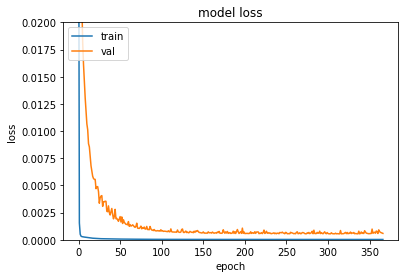

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.02])
plt.show()

<Strong> Testing our model on the validation data once again , hyper-parameter adjustment. <Strong>

In [50]:
validation_predict = model.predict(btc_val[0])
validation_predict = scaler.inverse_transform(validation_predict)

validation_actual = scaler.inverse_transform(btc_val[1])
mean_absolute_error(validation_actual , validation_predict)

268.4803778372762

<Strong> Combining the train and validation set when perfected hyper-parameters and training on fresh model. </Strong>

In [51]:
train_and_val = np.concatenate([btc_train[0] , btc_val[0]] )
train_and_val_targets = np.concatenate([btc_train[1] , btc_val[1] ])

freshModel = tf.keras.Model(inputs=inputs, outputs= x)

freshModel.compile(optimizer='adam' , loss = 'mse')
final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs )

Epoch 1/366
69/69 [==============================] - 1s 6ms/step - loss: 0.0161
Epoch 2/366
69/69 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 3/366
69/69 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 4/366
69/69 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 5/366
69/69 [==============================] - 0s 6ms/step - loss: 7.9884e-04
Epoch 6/366
69/69 [==============================] - 0s 6ms/step - loss: 5.9821e-04
Epoch 7/366
69/69 [==============================] - 0s 6ms/step - loss: 3.4952e-04
Epoch 8/366
69/69 [==============================] - 0s 6ms/step - loss: 3.5009e-04
Epoch 9/366
69/69 [==============================] - 0s 6ms/step - loss: 3.3944e-04
Epoch 10/366
69/69 [==============================] - 0s 6ms/step - loss: 2.8146e-04
Epoch 11/366
69/69 [==============================] - 0s 6ms/step - loss: 2.8353e-04
Epoch 12/366
69/69 [==============================] - 0s 6ms/step - loss: 2.3441e-04
Epoch

In [52]:
test_predict = freshModel.predict(btc_test[0])
test_actual = btc_test[1]

In [53]:
print(mean_absolute_error(test_actual , test_predict))
print(mean_absolute_percentage_error(test_actual , test_predict))
print(mean_squared_error(test_actual , test_predict , squared = False))
print(mean_squared_error(test_actual , test_predict))

0.014438867157879462
0.005216137610984723
0.020877304064957046
0.000435861825020672


<Strong> For Predicting more than 1 day in the future - Test Set. </Strong>

In [54]:
def steps_in_future(hours_in_future , data):
    
    #All the hours_in_future time predictions
    predictions = []
    
    # Have to cut off the (hours_in_future - 1) off the test set to avoid out of bounds error
    test_data = data[0][:-(hours_in_future - 1)]
    
    for x in range (len(test_data)):
        #Going through all the windows
        last_window = test_data[x].reshape(1,-1)
    
            # Make as many predictions as hours_in_future
        for i in range(hours_in_future):
            
            # Take the predicted value from the last window in training set
            last_prediction = model.predict(last_window)[0]

            #shifting the window size one step down
            last_window[0] = np.roll(last_window[0], -1)

            #replacing the old value with new prediction
            last_window[0 , (len(last_window[0]) - 1)] = last_prediction

        #append prediction
        predictions.append(last_prediction)
    
    return predictions

In [55]:
three_day_predictions = steps_in_future(3, btc_test)
five_day_predictions = steps_in_future(5, btc_test)
seven_day_predictions = steps_in_future( 7, btc_test)
nine_day_predictions = steps_in_future( 9, btc_test)
eleven_day_predictions = steps_in_future( 11, btc_test)

In [56]:
# Targets to compare  

targets_in_future_three = btc_test[1][(3 - 1):]
targets_in_future_five = btc_test[1][(5 - 1):]
targets_in_future_seven = btc_test[1][(7 - 1):]
targets_in_future_nine = btc_test[1][(9 - 1):]
targets_in_future_eleven = btc_test[1][(11 - 1):]

In [57]:
def get_eval_metrics(num_days , actual , results):
    
    mae = mean_absolute_error(actual , results)
    mse = mean_squared_error(actual , results )
    rmse = mean_squared_error(actual , results , squared = False)
    mape = mean_absolute_percentage_error(actual , results)

    print(num_days , "MAE :" , mae ,"MSE :" , mse , "RMSE :" , rmse , "MAPE :" , mape)

    return mae , mse , rmse , mape

In [58]:
three_days_mae , three_days_mse , three_days_rmse , three_days_mape = get_eval_metrics("Three Hour Forecast" , targets_in_future_three , three_day_predictions)
five_days_mae , five_days_mse , five_days_rmse , five_days_mape = get_eval_metrics("Five Hour Forecast" , targets_in_future_five , five_day_predictions)
seven_days_mae , seven_days_mse , seven_days_rmse , seven_days_mape = get_eval_metrics("Seven Hour Forecast" , targets_in_future_seven , seven_day_predictions)
nine_days_mae , nine_days_mse , nine_days_rmse , nine_days_mape = get_eval_metrics("Nine Hour Forecast" , targets_in_future_nine , nine_day_predictions)
eleven_days_mae , eleven_days_mse , eleven_days_rmse , eleven_days_mape = get_eval_metrics("Eleven Hour Forecast" , targets_in_future_eleven , eleven_day_predictions)



Three Hour Forecast MAE : 0.02570014409877148 MSE : 0.0013656193450933408 RMSE : 0.036954287235628575 MAPE : 0.009304614368876796
Five Hour Forecast MAE : 0.0364438526834709 MSE : 0.0025710274023897136 RMSE : 0.05070529954935395 MAPE : 0.013318433685971055
Seven Hour Forecast MAE : 0.04952805637124852 MSE : 0.004319924083166665 RMSE : 0.06572612937916446 MAPE : 0.018341387406544774
Nine Hour Forecast MAE : 0.06598236213110781 MSE : 0.006998285178958038 RMSE : 0.08365575400985899 MAPE : 0.024760771259144713
Eleven Hour Forecast MAE : 0.08547451070547604 MSE : 0.010884885342854676 RMSE : 0.10433065389833746 MAPE : 0.03247017906734091
